In [163]:
#import dependencies
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [164]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [165]:
# create engine
engine = create_engine("sqlite:///hawaii.sqlite")

In [166]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [167]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [168]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [169]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


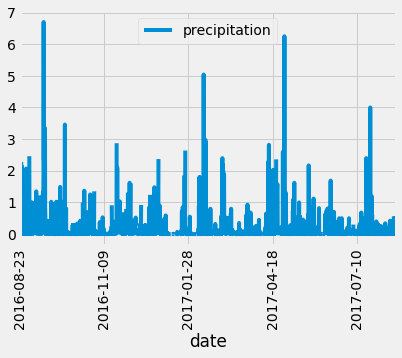

In [170]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
#Starting from the last data point in the database. 
prev_year = dt.date(2017, 8, 23)

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
df = pd.DataFrame(results, columns=['date','precipitation'])
df.set_index(df['date'], inplace=True)

# Sort the dataframe by date
df = df.sort_index()
#print(df.to_string(index=False))

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)

# Use Pandas to calcualte the summary statistics for the precipitation data
df.describe()


In [171]:
# How many stations are available in this dataset?
session.query(func.count(Station.station)).all()

[(9)]

In [172]:
# What are the most active stations?
# List the stations and the counts in descending order.
session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [173]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.station == 'USC00519281').all()


[(54.0, 85.0, 71.66378066378067)]

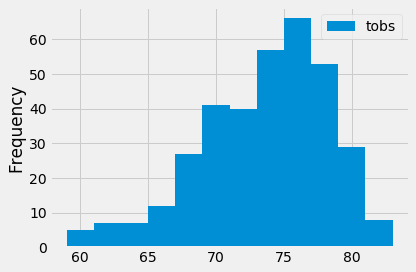

In [174]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).filter(Measurement.station == 'USC00519281').filter(Measurement.date >= prev_year).all()
df = pd.DataFrame(results, columns=['tobs'])

df.plot.hist(bins=12)
plt.tight_layout()


In [175]:
# Write a function called `calc_temps` that will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# Testing function
start_date = '2017-06-01'
end_date = '2017-06-30'

temp_stats = calc_temps(start_date, end_date)

print(temp_stats)


[(71.0, 83.0, 77.21989528795811)]


# Challenge

In [176]:
# Perform a query to retrieve all data and precipitation scores. We are using .filter to remove days with NaN making the assumption that NaN means that the station didn't receive data versus value = 0.00 meaning that he didn't rain.
all_dates_results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.prcp >= 0).all()

# Save the query results as a Pandas DataFrame and set the index to the date column and sort the dataframe by date
all_dates_df = pd.DataFrame(all_dates_results, columns=['date','precipitation'])

# Converting date to datetime to access specific month later.
all_dates_df['date'] = pd.to_datetime(all_dates_df['date'])

all_dates_df.describe()


,precipitation
count,18103.000000
mean,0.160644
std,0.468746
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,11.530000


In [177]:
# Identify key statistical data in June across all of the stations and years using the describe() function
all_june_dates = all_dates_df.loc[all_dates_df['date'].dt.month == 6]

all_june_dates.describe()

,precipitation
count,1574.000000
mean,0.136360
std,0.335731
min,0.000000
25%,0.000000
50%,0.020000
75%,0.120000
max,4.430000


In [178]:
# Identify key statistical data in December across all stations and years using the describe() function.
all_december_dates = all_dates_df.loc[all_dates_df['date'].dt.month == 12]

all_december_dates.describe()

,precipitation
count,1405.000000
mean,0.216819
std,0.541399
min,0.000000
25%,0.000000
50%,0.030000
75%,0.150000
max,6.420000


# **Key differences in weather between June and December.**
***

Stats All Dates | Stats June | Stats December
- | - | -
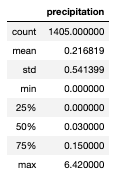 | 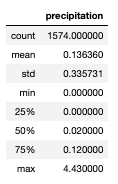 | 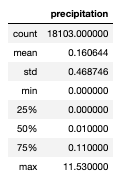

### Observations on how we pulled the data:
- The raw dataset we explored spanned from 01/01/2010 to 08/23/2017.
- Using a filter in the query, we excluded all rows that contained a NaN value as we made the assumption that the station was not able to retrieve a data read on that day.
- We converted the date column to datetime type to be able to manipulate and access a specific month range.

### Here is what we observe when comparing the three tables:
- There are more data points available for June (1574) than for December (1405) across the dataset. This might suggest a data retrieval issue for one or several of the stations.
- The average daily precipitation is about 0.14 inches in June and about 0.22 inches in December. If we compare to the average of the entire data set (0.16 inches), we notice that June gets 12.5% less rain than overall and December gets 37.5% more rain than overall.
- The standard deviation is about 0.34 inches in June and about 0.54 inches in December. We notice that June's standard deviation is closer the mean than for December. If we compare to the standard deviation of the entire data set (0.47 inches), we notice that December has a higher standard deviation which suggests that they have some heavier days of rain in December compared to June.
- To corroborate this last point, we notice that 75% of the data points are below 0.12 inches in June and below 0.15  inches in December, which is lower than the mean in both cases. When looking at the max for both June and December, we notice that it is 13 standard deviation higher than the mean for June and 29 standard deviation higher than the mean for December. This tells us that there is some outliers in the data set that skewing the right for both months.

# **Recommendations for further analysis.**
***

### Here is a few recommendations to dive a little deeper in the dataset:
- We could break down the analysis by stations and identify the most reliable station for the date range we're analyzing for. This would help make our analysis more accurate.
- The analysis compares only two months of the year. While we can use these as a reference for the season, it would be interesting to get the statistics for every month to be able to identify the ideal period to start/keep open the business.
- The analysis is done at the month level. Once we've narrowed down the best month to open the business, it would be interesting to look at weekly/daily trends of precipitations for that specific month to identify if there is a pattern over the past 7 years. For example, this could help us predict days of rain in advance and set up discounts on ice cream for those days to keep the business going.
- We noticed that the data set is skewed to the right. It would be worth removing the outliers from the data set to have a more precise mean calculation for both months.

